In [1]:
import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); Pkg.instantiate()
using TrajectoryOptimization
import TrajectoryOptimization: get_times
using RobotDynamics
import RobotZoo.Acrobot
using StaticArrays
using SparseArrays
using LinearAlgebra
using ForwardDiff
using PyPlot
using OSQP
using Plots
include("acrobot.jl")
include("utils.jl")

 Activating environment at `~/Classes/OptimalControl/hw4_solutions/Project.toml`


HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-12235939986657469454\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-6605469231624402173\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-12235939986657469454\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

slerp (generic function with 1 method)

# Question 3: Iterative Learning Control
In this problem we'll be exploring the use of iterative learning control (ILC) to update our trajectories to work on a "real" system with some un-modeled system dynamics. We'll first find an optimalized trajectory using our approximate model, and then refine those trajectories using ILC to achieve the desired behavior. 

## Dynamics
We'll keep things simple by applying this to the "acrobot" system, which is just a double pendulum with actuation only at the elbow joint. We'll use the model out of RobotZoo.

## Setting up the Optimization problem
We'll use TrajectoryOptimization.jl to define our problem. We specify an initial and terminal constraint, a quadratic cost function that penalizes distance from the goal, and bounds on the torques. 

In [2]:
# Dynamics Model
l0 = @SVector [1.0, 1.0]
m0 = @SVector [1.0, 1.0]
J0 = @SVector [(1.0/12)*m0[1]*l0[1]*l0[1], (1.0/12)*m0[2]*l0[2]*l0[2]]
model = Acrobot(l0, m0, J0)
n,m = size(model);

# Discretization
N = 101
Tf = 5.
h = Tf/(N-1)

# Initial and Final Conditions
x0 = @SVector [-pi/2, 0, 0, 0]
xf = @SVector [pi/2, 0, 0, 0];  # i.e. swing up

# Objective
Q = 100.0*Diagonal(@SVector ones(n))
Qf = 1000.0*Diagonal(@SVector ones(n))
R = 1.0*Diagonal(@SVector ones(m))
obj = LQRObjective(Q,R,Qf,xf,N);

# Constraints
conSet = ConstraintList(n,m,N)

#   Control bounds
u_bnd = 20.0
bnd = BoundConstraint(n,m, u_min=-u_bnd, u_max=u_bnd)
add_constraint!(conSet, bnd, 1:N-1)

#   Goal constraint
goal = GoalConstraint(xf)
add_constraint!(conSet, goal, N)

# Define the problem
prob = Problem(model, obj, xf, Tf, x0=x0, constraints=conSet, integration=RK4);

# Initial controls
U0 = [randn() for k = 1:N-1]
initial_controls!(prob, U0)
rollout!(prob);

## Solving the Problem
We'll make it easy for you and and solve the problem using ALTRO. Run the code below to solve for the optimized trajectory and visualize the result.

In [3]:
using Altro
using Random
opts = SolverOptions(
    iterations=100000,
    constraint_tolerance=1e-4,
#     cost_tolerance_intermediate=1e-4,
#     cost_tolerance=1e-6,
    #gradient_tolerance=1e-4,
    #gradient_tolerance_intermediate=1e-4,
    projected_newton=0,
#     verbose_pn=1,
#     active_set_tolerance_pn=1e-2,
    verbose=0
)

Random.seed!(1)
U0 = [randn() for k = 1:N-1]
initial_controls!(prob, U0)

altro = ALTROSolver(prob, opts)
set_options!(altro, show_summary=true)
solve!(altro);


SOLVE COMPLETED
 solved using the ALTRO Solver,
 part of the Altro.jl package developed by the REx Lab at Stanford and Carnegie Mellon Universities

  Solve Statistics
    Total Iterations: 877
    Solve Time: 2167.431303 (ms)

  Covergence
    Terminal Cost: 5607.5892866843205
    Terminal dJ: 1.442316897737328e-5
    Terminal gradient: 0.009015517830683833
    Terminal constraint violation: 3.501533653182953e-5
    Solve Status: SOLVE_SUCCEEDED


In [4]:
vis = Visualizer()
set_mesh!(vis, model)
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8700
└ @ MeshCat /home/brian/.julia/packages/MeshCat/GlCMx/src/visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("base" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x62, 0x61, 0x73, 0x65], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()),"link1" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x6c, 0x69, 0x6e, 0x6b, 0x31], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("joint" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x69, 0x6e, 0x6b, 0x31, 0x2f, 0x6a, 0x6f, 0x69, 0x6e, 0x74], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x69, 0x6e, 0x6b, 0x31, 0x2f, 0x6a, 0x6f, 0x69, 0x6e, 0x74], Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()),"link2" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x69, 0x6e, 0x6b, 0x31, 0x2f, 0x6c, 0x69, 0x6e, 0x6b, 0x32], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x69, 0x6e, 0x6b, 0x31, 0x2f, 0x6c, 0x69, 0x6e, 0x6b, 0x32], Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()))))))))), Set{Any}(), ip"127.0.0.1", 8700))

In [5]:
visualize!(vis, model, Tf, states(altro))

## Part (a): Design a TVLQR controller to track the trajectory

In [6]:
function linearize(model, X, U, times)
    n,m = size(model)
    N = length(X)
    A = [zeros(n,n) for k = 1:N-1]
    B = [zeros(n,m) for k = 1:N-1]
    ∇f = RobotDynamics.DynamicsJacobian(model)
    for k = 1:N-1
        dt = times[k+1] - times[k]
        z = KnotPoint(X[k], U[k], dt, times[k])
        discrete_jacobian!(RK4, ∇f, model, z)
        A[k] .= ∇f.A
        B[k] .= ∇f.B
    end
    A,B
end
function tvlqr(A,B, Q,R,Qf=Q)
    n,m = size(B[1])
    N = length(A)+1
    K = [zeros(m,n) for k = 1:N-1]
    P = [zeros(n,n) for k = 1:N]
    P[end] .= Qf
    for k = reverse(1:N-1)
        K[k] .= (R + B[k]'P[k+1]*B[k])\(B[k]'P[k+1]*A[k])
        P[k] .= Q + A[k]'P[k+1]*A[k] - A[k]'P[k+1]*B[k]*K[k]
    end
    return K,P
end
A,B = linearize(model, states(altro), controls(altro), get_times(altro))
K,P = tvlqr(A,B, Q,R,Qf);

In [7]:
function sim(model::Acrobot, K, Xref, Uref, times; u_bnd=20.0, x0=Xref[1])
    n,m = size(model)
    N = length(K) + 1
    X = [@SVector zeros(n) for k = 1:N]
    U = [@SVector zeros(m) for k = 1:N-1]
    X[1] = x0
    for k = 1:N-1
        dt = times[k+1] - times[k]
        U[k] = Uref[k] - K[k]*(X[k] - Xref[k])
        U[k] = clamp.(U[k], -u_bnd, u_bnd)
        X[k+1] = true_dynamics_rk4(model, X[k], U[k], dt)
    end
    return X, U
end
Xsim,Usim = sim(model, K, states(altro), controls(altro), get_times(altro));

In [9]:
render(vis)

MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String,MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("base" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x62, 0x61, 0x73, 0x65], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()),"link1" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x6c, 0x69, 0x6e, 0x6b, 0x31], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("joint" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x69, 0x6e, 0x6b, 0x31, 0x2f, 0x6a, 0x6f, 0x69, 0x6e, 0x74], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x69, 0x6e, 0x6b, 0x31, 0x2f, 0x6a, 0x6f, 0x69, 0x6e, 0x74], Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()),"link2" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x69, 0x6e, 0x6b, 0x31, 0x2f, 0x6c, 0x69, 0x6e, 0x6b, 0x32], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x69, 0x6e, 0x6b, 0x31, 0x2f, 0x6c, 0x69, 0x6e, 0x6b, 0x32], Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()))))))))), Set(Any[WebSocket(server, CONNECTED)]), ip"127.0.0.1", 8700))

In [10]:
visualize!(vis, model, Tf, Xsim)

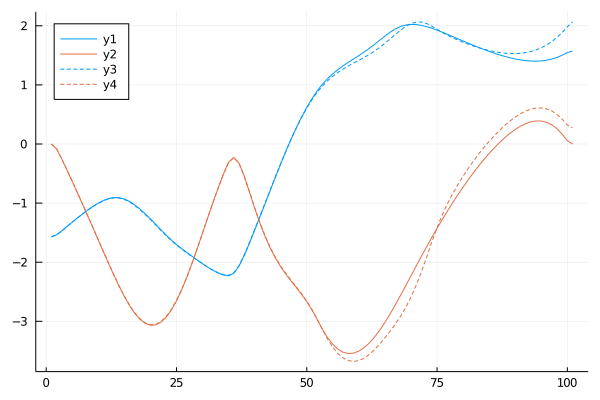

In [11]:
Plots.plot(states(altro), inds=1:2)
Plots.plot!(Xsim, inds=1:2, color=[1 2], ls=:dash, legend=:topleft)

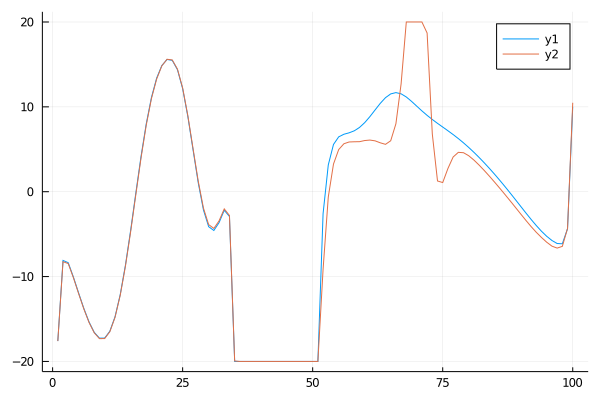

In [12]:
Plots.plot(controls(altro))
Plots.plot!(Usim)

## Part (b)

In [13]:
struct ILCData2{n,m,T}
    Q::Diagonal{T,SVector{n,T}}
    R::Diagonal{T,SVector{m,T}}
    Qf::Diagonal{T,SVector{n,T}}
    Xref::Vector{SVector{n,T}}
    Uref::Vector{SVector{m,T}}
    times::Vector{T}
    u_bnd::T
end
function build_qp(data::ILCData2, Xsim, Usim, A,B,K)
    Nh = length(data.Xref)
    n,m = size(B[1])
    Xref,Uref = data.Xref, data.Uref
    
    # Cost
    Qilc = sparse(data.Q)
    Rilc = sparse(data.R)
    H = blockdiag(kron(I(Nh-2), blockdiag(Rilc, Qilc)), Rilc, sparse(data.Qf))
    q = zeros((n+m)*(Nh-1))
    for k = 1:(Nh-2)
        q[(k-1)*(m+n) .+ (1:(m+n))] .= [0.0; Qilc*(Xsim[k+1]-Xref[k+1])]
    end
    q[(Nh-2)*(m+n) .+ (1:(m+n))] .= [0.0; Qf*(Xsim[Nh]-Xref[Nh])]
    
    # Constraints
    U = kron(I(Nh-1), [I zeros(m,n)]) #Matrix that picks out all u
    X = kron(I(Nh-1), [zeros(n,m) I]) #Matrix that picks out all x
    D = spzeros(n*(Nh-1), (n+m)*(Nh-1)) #dynamics constraints
    D[1:n,1:m] .= B[1]
    D[1:n,(m+1):(m+n)] .= -I(n)
    for k = 1:(Nh-2)
        D[(k*n).+(1:n), (m+(k-1)*(n+m)).+(1:(2*n+m))] .= [(A[k+1]-B[k+1]*K[k+1]) B[k+1] -I]
    end
    Ubar = hcat(Vector.(Uref)...)
    lb = [zeros(n*(Nh-1)); -u_bnd .- vec(Ubar)]
    ub = [zeros(n*(Nh-1)); +u_bnd .- vec(Ubar)]
    
    # Build QP
    qp = OSQP.Model()
    OSQP.setup!(
        qp, P=H, q=q, A=[D; U], l=lb, u=ub, 
        eps_abs=1e-6, eps_rel=1e-6, eps_prim_inf = 1.0e-6, eps_dual_inf = 1.0e-6, polish=1, verbose=0
    )
    return qp
end

function update_qp!(qp::OSQP.Model, data, X, U)
    Nh = length(data.Xref)
    n,m = length(X[1]), length(U[1])
    Qilc, Rilc, Qf = data.Q, data.R, data.Qf
    q = zeros((n+m)*(Nh-1))
    for k = 1:(Nh-2)
        q[(k-1)*(m+n) .+ (1:(m+n))] .= [0.0; Qilc*(X[k+1]-data.Xref[k+1])]
    end
    q[(Nh-2)*(m+n) .+ (1:(m+n))] .= [0.0; Qf*(X[Nh]-data.Xref[Nh])]
    OSQP.update_q!(qp, q)
    return q
end

update_qp! (generic function with 1 method)

In [40]:
function run_ilc(altro)
    # Get nominal trajectory
    Xnom = states(altro)
    Unom = controls(altro);
    n,m,Nh = size(altro)
    
    # Get costs out of solver
    Q = get_objective(altro).obj[1].Q
    R = get_objective(altro).obj[1].R
    Qf = get_objective(altro).obj[end].Q
    
    # Get bound out of solver
    u_bnd = get_constraints(altro).convals[1].con.z_max[end]
    
    # ILC Cost functions    
    Qilc = Diagonal(SA[1.0; 1.0; 1.0; 1.0])
    Rilc = Diagonal(SA[0.1])
    
    # Generate ILC Data
    data = ILCData2(Qilc,Rilc,Qf, Xnom, Unom, get_times(altro), u_bnd);
    
    # Generate Tracking Controller
    A,B = linearize(model, states(altro), controls(altro), get_times(altro))
    K,P = tvlqr(A,B, Q,R,Qf);
    U = kron(I(Nh-1), [I zeros(m,n)]) #Matrix that picks out all u
    
    # Generate first problem
    Xsim,Usim = sim(model, K, Xnom, Unom, get_times(altro));
    @show norm(Xsim - Xnom)
    qp0 = build_qp(data, Xsim, Usim, A,B,K);
    
    for iter = 1:10
        # Solve QP and modify feedforward controls
        res0 = OSQP.solve!(qp0)
        Δu = reshape(U*res0.x, m, N-1)
        for k = 1:N-1
            Unom[k] += Δu[:,k]
        end
        
        # Simulate the system with the new feedforward controls
        Xsim,Usim = sim(model, K, Xnom, Unom, get_times(altro));
        @show norm(Xsim - Xnom)
        
        # Update the QP
        data.Uref .= Unom
        q0 = update_qp!(qp0, data, Xsim, Usim)
        
    end
    return Xsim
end

run_ilc (generic function with 2 methods)

In [42]:
Xilc = run_ilc(altro);

norm(Xsim - Xnom) = 5.845134979693264
norm(Xsim - Xnom) = 3.9493868656925684
norm(Xsim - Xnom) = 3.0839283195111937
norm(Xsim - Xnom) = 2.53294897742927
norm(Xsim - Xnom) = 2.2261476126300357
norm(Xsim - Xnom) = 2.1279110596302027
norm(Xsim - Xnom) = 2.0998315134651024
norm(Xsim - Xnom) = 2.08866283610263
norm(Xsim - Xnom) = 2.08789025438654
norm(Xsim - Xnom) = 2.0932890102768322
norm(Xsim - Xnom) = 2.1017910204069263


In [43]:
render(vis)

MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String,MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("base" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x62, 0x61, 0x73, 0x65], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()),"link1" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x6c, 0x69, 0x6e, 0x6b, 0x31], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("joint" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x69, 0x6e, 0x6b, 0x31, 0x2f, 0x6a, 0x6f, 0x69, 0x6e, 0x74], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x69, 0x6e, 0x6b, 0x31, 0x2f, 0x6a, 0x6f, 0x69, 0x6e, 0x74], Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()),"link2" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x69, 0x6e, 0x6b, 0x31, 0x2f, 0x6c, 0x69, 0x6e, 0x6b, 0x32], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x69, 0x6e, 0x6b, 0x31, 0x2f, 0x6c, 0x69, 0x6e, 0x6b, 0x32], Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()))))))))), Set(Any[WebSocket(server, CONNECTED), WebSocket(server, CONNECTED)]), ip"127.0.0.1", 8700))

In [45]:
visualize!(vis, model, Tf, Xilc)

norm(Xsim - Xnom) = 2.1112986944540393


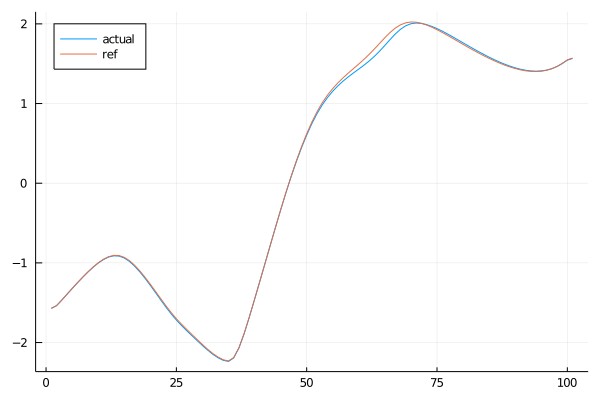

In [668]:
Xsim,Usim = sim(model, K0, Xnom, Unom, get_times(altro));
@show norm(Xsim - Xnom)
Plots.plot(Xsim, inds=1:1, label="actual", legend=:topleft)
Plots.plot!(Xnom, inds=1:1, label="ref")

In [669]:
q0 = update_qp!(qp0, data, Xsim, Usim)
# OSQP.update_q!(qp0, q0)
res0 = OSQP.solve!(qp0)
Δu = reshape(U*res0.x, m, N-1)
for k = 1:N-1
    Unom[k] += Δu[:,k]
end
data.Uref .= Unom

iter   objective    pri res    dua res    rho        time
   1  -4.8820e-02   2.05e-03   6.14e-01   5.39e-04   5.67e-05s
 200  -5.2040e-02   3.40e-06   6.32e-06   5.39e-04   3.89e-03s
 350  -5.2245e-02   1.28e-06   2.37e-06   5.39e-04   6.66e-03s
plsh  -5.2367e-02   4.28e-16   3.73e-10   --------   7.00e-03s

status:               solved
solution polish:      successful
number of iterations: 350
optimal objective:    -0.0524
run time:             7.00e-03s
optimal rho estimate: 8.76e-04



100-element Array{SArray{Tuple{1},Float64,1,1},1}:
 [-17.795214321228595]
 [-8.210733672994055]
 [-8.448771976770566]
 [-10.13299439667559]
 [-12.001865137547844]
 [-13.810046144135017]
 [-15.414943400557764]
 [-16.65954891013627]
 [-17.380962927226616]
 [-17.431620717244904]
 [-16.691380270904045]
 [-15.075203473561352]
 [-12.5508894379228]
 ⋮
 [-0.6102580955510715]
 [-1.3720613900151708]
 [-2.1330501372093713]
 [-2.8827226443058636]
 [-3.6171637561329977]
 [-4.379999592262888]
 [-5.077654892285131]
 [-5.586235254103115]
 [-5.944788801030508]
 [-5.974823849451221]
 [-4.194139702441263]
 [9.985256363942955]

In [623]:
# Extract the solution
Xopt = states(altro);
Uopt = controls(altro);

xnom = zeros(n,N)
for k = 1:N
    xnom[:,k] .= Xopt[k]
end

unom = zeros(m,N-1)
utraj = zeros(m,N-1)
for k = 1:N-1
    unom[:,k] .= Uopt[k]
    utraj[:,k] .= Uopt[k]
end

In [505]:
function dynamics_rk4(x, u)
    #RK4 integration with zero-order hold on u
    f1 = dynamics(model, x, u)
    f2 = dynamics(model, x + 0.5*h*f1, u)
    f3 = dynamics(model, x + 0.5*h*f2, u)
    f4 = dynamics(model, x + h*f3, u)
    return x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
end

#True model with friction
function true_dynamics(model::Acrobot, x, u)
    g = 9.81
    
    #Perturb model parameters
    m1 = model.m[1] + 0.01
    m2 = model.m[2] - 0.01
    l1 = model.l[2] - 0.005
    l2 = model.l[2] + 0.004
    J1 = (1.0/12)*m1*l1*l1
    J2 = (1.0/12)*m2*l2*l2
    
    θ1,    θ2    = x[1], x[2]
    θ1dot, θ2dot = x[3], x[4]
    s1,c1 = sincos(θ1)
    s2,c2 = sincos(θ2)
    c12 = cos(θ1 + θ2)

    # mass matrix
    m11 = m1*l1^2 + J1 + m2*(l1^2 + l2^2 + 2*l1*l2*c2) + J2
    m12 = m2*(l2^2 + l1*l2*c2 + J2)
    m22 = l2^2*m2 + J2
    M = @SMatrix [m11 m12; m12 m22]

    # bias term
    tmp = l1*l2*m2*s2
    b1 = -(2 * θ1dot * θ2dot + θ2dot^2)*tmp
    b2 = tmp * θ1dot^2
    B = @SVector [b1, b2]

    # friction
    c = 1.0
    C = @SVector [0.1*tanh(5*θ1dot) + c*θ1dot, 0.1*tanh(5*θ2dot) + c*θ2dot] #add nonlinear friction to model

    # gravity term
    g1 = ((m1 + m2)*l2*c1 + m2*l2*c12) * g
    g2 = m2*l2*c12*g
    G = @SVector [g1, g2]

    # equations of motion
    τ = @SVector [0, u[1]]
    θddot = M\(τ - B - G - C)
    return @SVector [θ1dot, θ2dot, θddot[1], θddot[2]]
end

function true_dynamics_rk4(x,u)
    #RK4 integration with zero-order hold on u
    f1 = true_dynamics(model, x, u)
    f2 = true_dynamics(model, x + 0.5*h*f1, u)
    f3 = true_dynamics(model, x + 0.5*h*f2, u)
    f4 = true_dynamics(model, x + h*f3, u)
    return x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
end

true_dynamics_rk4 (generic function with 3 methods)

In [506]:
#Compute A and B matrices using nominal dynamics + trajectory
A = zeros(n,n,N-1)
B = zeros(n,m,N-1)
for k = 1:(N-1)
    A[:,:,k] .= ForwardDiff.jacobian(x->dynamics_rk4(x,Uopt[k]),Xopt[k])
    B[:,:,k] .= ForwardDiff.jacobian(u->dynamics_rk4(Xopt[k],u),Uopt[k])
end

In [507]:
#Compute LQR Tracking Controller
P = zeros(n,n,N)
K = zeros(m,n,N-1)
P[:,:,N] = Qf
for k = (N-1):-1:1
    K[:,:,k] .= (R + B[:,:,k]'*P[:,:,k+1]*B[:,:,k])\(B[:,:,k]'*P[:,:,k+1]*A[:,:,k])
    P[:,:,k] .= Q + K[:,:,k]'*R*K[:,:,k] + (A[:,:,k]-B[:,:,k]*K[:,:,k])'*P[:,:,k+1]*(A[:,:,k]-B[:,:,k]*K[:,:,k])
end

In [577]:
#Rollout with true dynamics
xtraj = zeros(n,N)
xtraj[:,1] .= x0
for k = 1:(N-1)
    utraj[:,k] .= unom[:,k] - K[:,:,k]*(xtraj[:,k]-xnom[:,k]) #LQR tracking controller
    utraj[:,k] .= min.(u_bnd, max.(-u_bnd, utraj[:,k])) #clip values within torque limits
    xtraj[:,k+1] .= true_dynamics_rk4(xtraj[:,k], utraj[:,k])
end
norm(xtraj - xnom)

2.0932746084178464

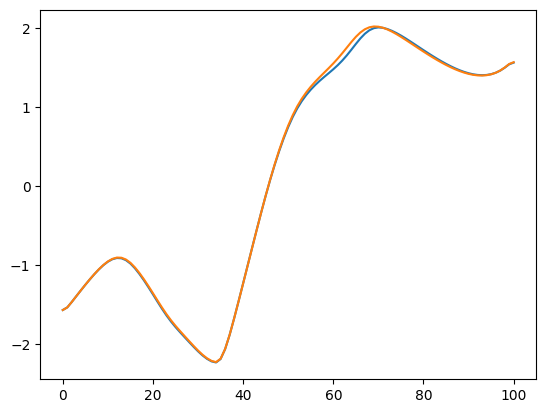

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fb86f83fe80>

In [578]:
plot(xtraj[1,:])
plot(xnom[1,:])

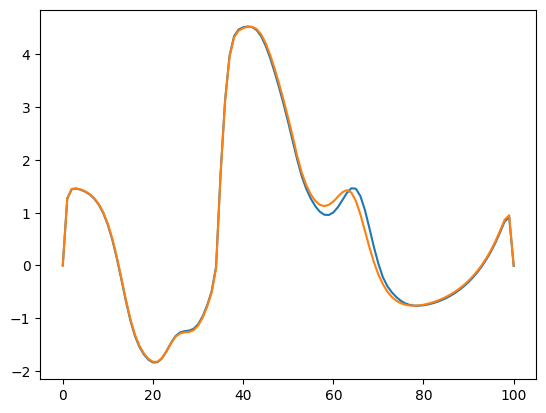

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fb86f798ee0>

In [579]:
plot(xtraj[3,:])
plot(xnom[3,:])

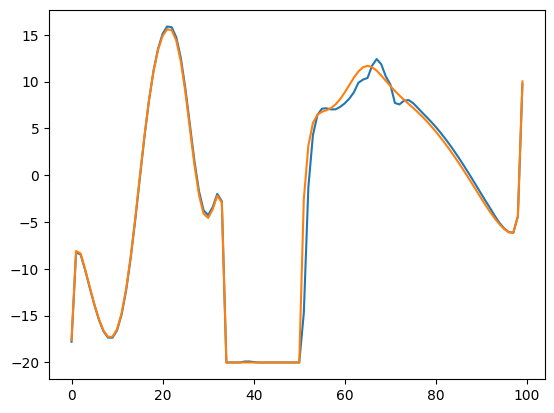

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fb86f778a00>

In [580]:
plot(utraj[1,:])
plot(Uopt[:])

In [582]:
#Build matrices for ILC QP
Nh = N
#Cost
Qilc = sparse(Diagonal([1.0; 1.0; 1.0; 1.0]))
Rilc = sparse(Diagonal([0.1]))
H = blockdiag(kron(I(Nh-2), blockdiag(Rilc, Qilc)), Rilc, sparse(Qf))
q = zeros((n+m)*(Nh-1))
for k = 1:(Nh-2)
    q[(k-1)*(m+n) .+ (1:(m+n))] .= [0.0; Qilc*(xtraj[:,k+1]-Xopt[k+1])]
end
q[(Nh-2)*(m+n) .+ (1:(m+n))] .= [0.0; Qf*(xtraj[:,Nh]-Xopt[Nh])]

#Constraints
U = kron(I(Nh-1), [I zeros(m,n)]) #Matrix that picks out all u
X = kron(I(Nh-1), [zeros(n,m) I]) #Matrix that picks out all x
D = spzeros(n*(Nh-1), (n+m)*(Nh-1)) #dynamics constraints

D[1:n,1:m] .= B[:,:,1]
D[1:n,(m+1):(m+n)] .= -I(n)
for k = 1:(Nh-2)
    D[(k*n).+(1:n), (m+(k-1)*(n+m)).+(1:(2*n+m))] .= [(A[:,:,k+1]-B[:,:,k+1]*K[:,:,k+1]) B[:,:,k+1] -I]
end

lb = [zeros(n*(Nh-1)); -u_bnd.-unom[1:(Nh-1)]]
ub = [zeros(n*(Nh-1)); u_bnd.-unom[1:(Nh-1)]]

qp = OSQP.Model()
OSQP.setup!(qp, P=H, q=q, A=[D; U], l=lb, u=ub, eps_abs=1e-6, eps_rel=1e-6, eps_prim_inf = 1.0e-6, eps_dual_inf = 1.0e-6, polish=1)
results = OSQP.solve!(qp)
ztraj = results.x;

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 500, constraints m = 500
          nnz(P) + nnz(A) = 2984
settings: linear system solver = qdldl,
          eps_abs = 1.0e-06, eps_rel = 1.0e-06,
          eps_prim_inf = 1.0e-06, eps_dual_inf = 1.0e-06,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.6105e+00   1.34e-01   5.42e+00   1.00e-01   6.59e-04s
 200  -9.0949e-02   4.99e-05   1.30e-04   1.49e+00   4.64e-03s
 400  -8.7605e-02   7.28e-06   1.90e-05   1.4

In [583]:
Δu = U*ztraj
unom[1:(Nh-1)] .= unom[1:(Nh-1)]+Δu

100-element view(::Array{Float64,1}, 1:100) with eltype Float64:
 -17.79001629101549
  -8.20786774063944
  -8.44502164579681
 -10.128162863960906
 -11.995917547759738
 -13.802997007025922
 -15.406615377340628
 -16.649274642975136
 -17.36745780526512
 -17.413082923023047
 -16.665820211028564
 -15.041116534985548
 -12.508198008033641
   ⋮
  -0.6136762010629453
  -1.376177285903819
  -2.1378260396977455
  -2.8879780263188084
  -3.6241572577904813
  -4.387377269750682
  -5.077551305808516
  -5.584292036664501
  -5.940939251045566
  -5.969292175682401
  -4.192853355135364
   9.98535593230853

In [576]:
Nh

101